# Generative Adverserial Networks (GAN)
<img src="https://thumbor.forbes.com/thumbor/960x0/https%3A%2F%2Fblogs-images.forbes.com%2Fwilliamfalcon%2Ffiles%2F2018%2F10%2Fedmond-de-belamy-framed-cropped.jpg" alt="drawing" width="800"/>

### AI Art at Christie’s Sells for 432,500 US Dollars
https://www.nytimes.com/2018/10/25/arts/design/ai-art-sold-christies.html

### Generative Models

Given training data, train a model that learns the distribution of training data and create new samples from the same distribution.

Discriminative models learn the decision boundary between classes, while the generative models learn the joint propability distribution of classes:

![https://kharshit.github.io/blog/2018/09/28/generative-models-and-generative-adversarial-networks](https://kharshit.github.io/img/discriminative_generative.png)
*Taken from https://kharshit.github.io/blog/2018/09/28/generative-models-and-generative-adversarial-networks*



![](images/overview.png)
*Taken from http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture13.pdf*




## Generative Adverserial Networks (GAN)

2 Networks: 
- Generator: learns to create realistic looking fake images
- Discriminator: learn to distinguish between fake and real (training data)

![](images/gan.png)


![](images/gan_paper.png)
*Taken from https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf*

### Demo GAN Lab
https://poloclub.github.io/ganlab/





### Loss function

Adverserial Loss:

<p style="text-align: center;">
$\min_G \max_D V(D, G)$
</p>

Min Max zero sum game: 
- ideally loss is zero
- GAN will reach the Nash equilibrium between generator and discriminator.


<p style="text-align: center;"> What could be the problem of GANs?</p>

### Convergence

<img src="images/loss.png" alt="drawing" width="1200"/>


### How to avoid unstable training

- Kernel size and filters
- Complexity of Generator
- Don’t mix batch of real and fake images
- Monitor Gradients
- Adding noise
- Feature Matching

### Training
![](https://cdn-images-1.medium.com/max/1280/1*fNGcuJDskQTNoPR_1C12_g.png)

### Uses Cases 

Image Impainting: https://arxiv.org/abs/1607.07539

        
![](images/Image_Impainting1.png)
        

### Use Cases

Deep Convolutional Generative Adverserial Network: https://arxiv.org/abs/1511.06434
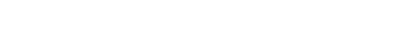

![](images/DCGAN.png)

### Use Cases 
Superresolution Generative Adverserial Network: https://arxiv.org/abs/1609.04802

![](images/superresolution.png)

### Use Cases

Cycle GAN: https://arxiv.org/abs/1703.10593
<img src="https://junyanz.github.io/CycleGAN/images/teaser_high_res.jpg" alt="drawing" width="1500"/>



### CycleGAN

In [ ]:
from data import train_cgan 
from data.train_cgan import define_G,Resize
import mxnet as mx
import numpy as np
import gluoncv as gcv
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from mxnet import nd, image
from mxnet.gluon.data.vision import transforms
from pylab import rcParams

In [1]:
rcParams['figure.figsize'] = 8, 8
ctx = mx.cpu()

netG = define_G(3, 64, 'resnet_9blocks',not 'store_false')
netG.load_parameters("data/netG_A_epoch_39.params")

transform_fn = transforms.Compose([
        Resize(256, keep_ratio=False, interpolation=3),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

img = image.imread("images/dog3.jpg")
plt.imshow(img.asnumpy())
plt.axis('off')
plt.show()


<Figure size 800x800 with 1 Axes>

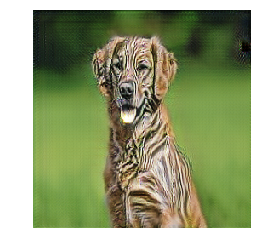

In [2]:
img = transform_fn(img)
img = img.expand_dims(0).as_in_context(ctx)
output = netG(img)
predict = mx.nd.squeeze(output)
predict = ((predict.transpose([1,2,0]).asnumpy() * 0.5 + 0.5) * 255).clip(0, 255).astype('uint8')
plt.imshow(predict)
plt.axis('off')
plt.show()

### Cycle-GAN

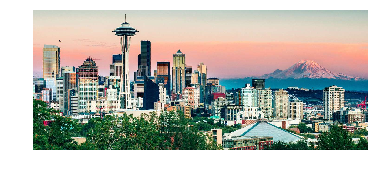

In [7]:
img = image.imread("images/seattle.jpg")
plt.imshow(img.asnumpy())
plt.axis('off')
plt.show()


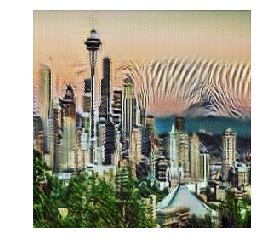

In [8]:
img = transform_fn(img)
img = img.expand_dims(0).as_in_context(ctx)
output = netG(img)
predict = mx.nd.squeeze(output)
predict = ((predict.transpose([1,2,0]).asnumpy() * 0.5 + 0.5) * 255).clip(0, 255).astype('uint8')
plt.imshow(predict)
plt.axis('off')
plt.show()

#### InfoGAN

https://arxiv.org/abs/1606.03657
- components are deeply entangled
- interpreting components can be difficult


<img src="images/gan1.png" alt="drawing" width="1200"/>


#### InfoGAN
![](images/gan2.png)


#### Mutual information
- measures mutual dependance between 2 variables
- if the mutual information between X and Y is high, then knowing Y helps you to decently predict the value of X
- maximize mutual information between latent codes c and generator output


#### InfoGAN Loss

Add regularization term consisting of mutual information between latent code c and generator output
<p style="text-align: center;">
$\min_G \max_D V(D, G) - \lambda I(c,G(z,c))$
</p>



- minimizing I(G(z, c); c) requires to know the distribution P(c|x), but P is unknown
- P is the likelihood of code c given the generated input x  
- use an “auxiliary” distribution”  Q(c|x) which is approximating P(c|x) 
- Q is modeled by a parameterized neural network (Re-parameterization trick)
- sample from a user-specified prior instead of the unknown posterior. 
- Find a variational lower bound of the mutual information.


![](images/infogan.png)

### Let's import the modules

In [9]:
from __future__ import print_function
from datetime import datetime
import logging
import multiprocessing
import os
import sys
import tarfile
import time

import numpy as np
from matplotlib import pyplot as plt
import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet import autograd

### Download training data

In [6]:
lfw_url = 'http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz'
data_path = 'lfw_dataset'
if not os.path.exists(data_path):
    os.makedirs(data_path)
    data_file = utils.download(lfw_url)
    with tarfile.open(data_file) as tar:
        tar.extractall(path=data_path)

### Define transform function

In [7]:
def transform(data, width=64, height=64):
    data = mx.image.imresize(data, width, height)
    data = nd.transpose(data, (2,0,1))
    data = data.astype(np.float32)/127.5 - 1
    if data.shape[0] == 1:
        data = nd.tile(data, (3, 1, 1))
    return data.reshape((1,) + data.shape)

### Read image files

In [8]:
def get_files(data_dir):
    images    = []
    filenames = []
    for path, _, fnames in os.walk(data_dir):
        for fname in fnames:
            if not fname.endswith('.jpg'):
                continue
            img = os.path.join(path, fname)
            img_arr = mx.image.imread(img)
            img_arr = transform(img_arr)
            images.append(img_arr)
            filenames.append(path + "/" + fname)
    return images, filenames

### Define dataloader

In [9]:
batch_size   = 64
data_dir = 'lfw_dataset'
images, filenames = get_files(data_dir)
split = int(len(images)*0.8)
test_images = images[split:]
test_filenames = filenames[split:]
train_images = images[:split]
train_filenames = filenames[:split]

train_data = gluon.data.ArrayDataset(nd.concatenate(train_images))
train_dataloader = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, last_batch='rollover', num_workers=multiprocessing.cpu_count()-1)

### Define hyperparameters

In [10]:
ctx = mx.cpu()
z_dim        = 100
n_continuous = 2
n_categories = 10

### Generator

In [11]:
class Generator(gluon.HybridBlock):
    
    def __init__(self, **kwargs):
    
        super(Generator, self).__init__(**kwargs)
        
        # Generator
        with self.name_scope():
            self.prev = nn.HybridSequential()
            self.prev.add(nn.Dense(1024, use_bias=False), nn.BatchNorm(), nn.Activation(activation='relu'))
            self.G = nn.HybridSequential()   
            self.G.add(nn.Conv2DTranspose(64 * 8, 4, 1, 0, use_bias=False))
            self.G.add(nn.BatchNorm())
            self.G.add(nn.Activation('relu'))
            self.G.add(nn.Conv2DTranspose(64 * 4, 4, 2, 1, use_bias=False))
            self.G.add(nn.BatchNorm())
            self.G.add(nn.Activation('relu'))
            self.G.add(nn.Conv2DTranspose(64 * 2, 4, 2, 1, use_bias=False))
            self.G.add(nn.BatchNorm())
            self.G.add(nn.Activation('relu'))
            self.G.add(nn.Conv2DTranspose(64, 4, 2, 1, use_bias=False))
            self.G.add(nn.BatchNorm())
            self.G.add(nn.Activation('relu'))
            self.G.add(nn.Conv2DTranspose(3, 4, 2, 1, use_bias=False))
            self.G.add(nn.Activation('tanh'))

    def hybrid_forward(self, F, x):
        x = self.prev(x)
        x = F.reshape(x, (0, -1, 1, 1))
        return self.G(x)

### Discriminator

In [12]:
class Discriminator(gluon.HybridBlock):
    
    def __init__(self, **kwargs):
        
        super(Discriminator, self).__init__(**kwargs)
        
        with self.name_scope():
            
            # Discriminator
            self.D = nn.HybridSequential()
            self.D.add(nn.Conv2D(64, 4, 2, 1, use_bias=False))
            self.D.add(nn.LeakyReLU(0.2))
            self.D.add(nn.Conv2D(64 * 2, 4, 2, 1, use_bias=False))
            self.D.add(nn.BatchNorm())
            self.D.add(nn.LeakyReLU(0.2))
            self.D.add(nn.Conv2D(64 * 4, 4, 2, 1, use_bias=False))
            self.D.add(nn.BatchNorm())
            self.D.add(nn.LeakyReLU(0.2))
            self.D.add(nn.Conv2D(64 * 8, 4, 2, 1, use_bias=False))
            self.D.add(nn.BatchNorm())
            self.D.add(nn.LeakyReLU(0.2))
            self.D.add(nn.Dense(1024, use_bias=False), nn.BatchNorm(), nn.Activation(activation='relu'))
            
            # Prediction: Fake or real
            self.prob = nn.Dense(1)
            
            # Estimate codes
            self.category_prob = nn.Dense(n_categories)
            self.continuous_mean = nn.Dense(n_continuous)
            self.feat = nn.HybridSequential()
            self.feat.add(nn.Dense(128, use_bias=False), nn.BatchNorm(), nn.Activation(activation='relu')) 
            
            # Q model 
            self.Q = nn.HybridSequential()
            self.Q.add(self.feat, self.category_prob, self.continuous_mean)

    def hybrid_forward(self, F, x):
        
        # Discriminator output
        x               = self.D(x)
        prob            = self.prob(x)
        feat            = self.feat(x)
        
        # Q model output
        category_prob   = self.category_prob(feat)
        continuous_mean = self.continuous_mean(feat)
        
        return prob, category_prob, continuous_mean

- Discriminator downsamples generator output
- Q model estimating categorical probability and continous mean from input image

### Create GAN 

In [13]:
# Create Generator
generator = Generator()
generator.hybridize()
generator.initialize(mx.init.Normal(0.002), ctx=ctx)

# Create Discriminator
discriminator = Discriminator()
discriminator.hybridize()
discriminator.initialize(mx.init.Normal(0.002), ctx=ctx)


### Define Trainer

In [14]:
# Learning rate
lr   = 0.0001

# exponential decay rate
beta = 0.5

# Trainer
g_trainer = gluon.Trainer(generator.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta})
d_trainer = gluon.Trainer(discriminator.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta})
q_trainer = gluon.Trainer(discriminator.Q.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta})

# Labels: real and fake 
real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = nd.zeros((batch_size,),ctx=ctx)



### Load a pretrained model

In [15]:
# Load pretrained model
if os.path.isfile('data/infogan_d_latest.params') and os.path.isfile('data/infogan_g_latest.params'):
    discriminator.load_parameters('data/infogan_d_latest.params', ctx=ctx, allow_missing=True, ignore_extra=True)
    generator.load_parameters('data/infogan_g_latest.params', ctx=ctx, allow_missing=True, ignore_extra=True)

### Define the loss functions

In [16]:
# Loss for Discriminator output
loss1 = gluon.loss.SigmoidBinaryCrossEntropyLoss()

# Loss for continouus codes
loss2 = gluon.loss.L2Loss()

# Loss for categorical codes
loss3 = gluon.loss.SoftmaxCrossEntropyLoss()

### Generator input

In [17]:
def create_generator_input():
    
    #create random noise
    z      = nd.random_normal(0, 1, shape=(batch_size, z_dim), ctx=ctx)
    
    # create categorical code vector
    label  = nd.array(np.random.randint(n_categories, size=batch_size)).as_in_context(ctx)
    c1     = nd.one_hot(label, depth=n_categories).as_in_context(ctx)
    
    # create continouus code vector
    c2     = nd.random.uniform(-1, 1, shape=(batch_size, n_continuous)).as_in_context(ctx)

    # concatenate random noise with c which will be the input of the generator
    return nd.concat(z, c1, c2, dim=1), label, c2

### Training Loop

In [18]:
for epoch in range(0):

    for idx, data in enumerate(train_dataloader):

        # Get real data and generator input
        real_data = data.as_in_context(ctx)     
        g_input, label, c2 = create_generator_input()


        # Update discriminator
        with autograd.record():
            
            # Real data
            output_real,_,_ = discriminator(real_data)
            
            # Discriminator loss for real data
            d_error_real    = loss1(output_real, real_label)

            # Fake data
            fake_image      = generator(g_input)
            output_fake,_,_ = discriminator(fake_image.detach())
            
            # Discriminator loss for fake data
            d_error_fake    = loss1(output_fake, fake_label)
            
            # Total Discriminator loss
            d_error         = d_error_real + d_error_fake


        #Update D every second iteration
        if (counter+1) % 2 == 0:
            d_error.backward()
            d_trainer.step(batch_size)

        #Update generator: Input random noise and latent code vector
        with autograd.record():
            
            # Random noise + code vectors
            fake_image = generator(g_input)
            
            # Discriminator output for fake data
            output_fake, category_prob, continuous_mean = discriminator(fake_image)
            
            # Generator loss
            g_error = loss1(output_fake, real_label) + loss3(category_prob, label) + loss2(c2, continuous_mean)

        g_error.backward()
 
        # Update Generator
        g_trainer.step(batch_size)
        
        # Update Q model
        q_trainer.step(batch_size)

### Training Loop

<img src="https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/info_gan/infogan.gif" alt="drawing" width="800"/>



### Image Similarity

In [19]:
discriminator = Discriminator()
discriminator.load_parameters("data/infogan_d_latest.params", ctx=ctx, ignore_extra=True)

discriminator = discriminator.D[:11]
print (discriminator)

discriminator.hybridize()

HybridSequential(
  (0): Conv2D(3 -> 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): LeakyReLU(0.2)
  (2): Conv2D(64 -> 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=128)
  (4): LeakyReLU(0.2)
  (5): Conv2D(128 -> 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=256)
  (7): LeakyReLU(0.2)
  (8): Conv2D(256 -> 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=512)
  (10): LeakyReLU(0.2)
)


In [20]:
# K-nearest neighbor
def get_knn(features, input_vector, k=3):
    dist = (nd.square(features - input_vector).sum(axis=1))/features.shape[0]
    indices = dist.asnumpy().argsort()[:k]
    return [(index, dist[index].asscalar()) for index in indices]

# Helper function for visualization
def visualize(img_array):
    plt.imshow(((img_array.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

In [ ]:
feature_size = 8192 

features = nd.zeros((len(test_images), feature_size), ctx=ctx)

# Load test images
for idx, image in enumerate(test_images):
  
    feature = discriminator(nd.array(image, ctx=ctx))
    feature = feature.reshape(feature_size,)
    features[idx,:] = feature.copyto(ctx)

# iterate over test images
for image in test_images[3:4]:

    # get feature vector for current image
    feature = discriminator(mx.nd.array(image, ctx=ctx))
    feature = feature.reshape((feature_size,))
    image   = image.reshape((3,64,64))

    # get nearest feature vectors
    indices = get_knn(features, feature, k=10)
    
    # plot
    fig = plt.figure(figsize=(15,12))
    plt.subplot(1,10,1)
    visualize(image)
    for i in range(2,9): 
        if indices[i-1][1] < 1.5:
            plt.subplot(1,10,i)
            sim = test_images[indices[i-1][0]].reshape(3,64,64)
            visualize(sim)
    plt.show()
    plt.clf()

<p style="text-align: center;"> Which image features are controlled by which latent code variable?</p>